# Intro to raytracing in python
Welcome to this introduction to ray tracing using the worlds most beautiful programing language, Python.
In this introduction we will build a ray-tracer.
This ray-tracer will only feature basic features, but understanding these is essential for doing more advanced ray-tracing work.
Although Python is awesome, it might not be the 'ideal' language for a ray tracer. Python is however very readable.
So if you want to program your own ray-tracer, by all means, do it in C, C++ or a similarly performant language.

## Part 1: In the beginning there was only triangles and rays

The 2 fundamental parts of a ray-tracer are rays and triangles.

In the world of computer graphics, triangles are a great way to create 3D models.
Using sufficiently many triangles you could make any 3D shape that you would ever want (even if sufficiently many can mean "infinitly many" with curved surfaces, but if you use enough, know one will be able to tell the difference.
It will look just like a curved surface, and that its just triangles can stay our little secret!)
The easies way to define a triangle is by means of its corner positions.
That is all info that we need right now!

![sphere from triangles](https://i.stack.imgur.com/RhJgj.gif)

To simulate light, we need to be able to simulate light rays. Because this is a basic ray-tracer, we will do something that might seem a bit weird.
instead of sending "photons" from our lamps and seeing how they fall onto the camera, as would happen in the real world, we will do the opposite.
We start  from the camera's point of view and look at the scene.

![Tracing from the camera](https://www.scratchapixel.com/images/upload/ray-tracing-refresher/rt-setup2.png?)

Lets start with a simple triangle class

In [217]:
class Triangle:
    def __init__(self, a, b, c):
        '''
        Basic triangle class.
        :param a: First corner
        :param b: Second corner
        :param c: Third corner
        '''
        self.a = a
        self.b = b
        self.c = c

Now we need the simple ray class


In [218]:
class Ray:
    def __init__(self, origin, direction):
        '''
        Basic ray class.
        :param origin: Origin/starting point of the ray
        :param direction: Direction of the ray
        '''
        self.origin = origin
        self.direction = direction
        


We already have our 2 most important classes!
It is time to move towards creating our first test image as soon as possible right?

Well, we will get there soon, I promise. But first, we need 4 more features for our ray-tracer.

## Part 2: When suddenly a wild camera appeared
The features that we need are:
- A little bit vector magic
- Ray triangle intersection testing
- A ray tracing function
- A camera 

We need some way to represent points in our virtual world. Vectors are a nice solution for ray tracing.
Using vectors we can define triangles, and rays!
We can even use it to locate our camera in the world ones we made a camera.
This is not a linear algebra course however, so I added a little MathUtil library to this project, which we can just import. 
Feel free to look into the MathUtil.py file if you want to learn more about the implementation of vectors.

Lets import the library and give some examples:

In [219]:
from math import *
from MathUtil import *

# Point_a is a point with:
# x = 1, y = 2, z = 3
point_a = Vec3(1,2,3)

# Point_b is a point with:
# x = -1, y = 5, z = 0
point_b = Vec3(-1,5,0)

# You can subtract vectors
point_c = point_a-point_b
print(f"Point_c: {point_c}")

# Or calculate the distance
dist = point_a.distance(point_b)
print(f"distance: {dist}")

Point_c: Vec3<2 -3 3>
distance: 4.69041575982343


There are quite some operations which we can do with vectors, and there are even 2D vectors in the Math Util library (named Vec2, as you might have guessed). 
I wont list them all here, but we will just use them when we need them.


Ray triangle intersection testing will be a bit more work, but this is the first interesting part!
![ray triangle intersection](https://la.mathworks.com/matlabcentral/mlc-downloads/downloads/submissions/49670/versions/3/screenshot.jpg)




In [220]:
#TODO rename other triangle
def ray_triangle_intersect(self, other):
    '''
    Test if the ray hits the triangle.
    :param self: The ray
    :param other: The triangle
    :return: Distance to triangle, 0/False is no hit
    '''
    
    # Calculate the vectors describing the edges of the triangle
    edge1 = other.b - other.a
    edge2 = other.c - other.a
    
    # Check if the ray and triangle are not parallel
    h = self.direction.cross_product(edge2)
    a = edge1.dot(h)

    if -EPSILON < a < EPSILON:
        return False
    
    # Calculate U/V (barycentric coordinates) of the hit on the triangle
    f = 1.0 / a
    s = self.origin - other.a
    u = f * (s.dot(h))
    
    q = s.cross_product(edge1)
    v = f * self.direction.dot(q)

    # The U must be between 0 and one
    if u < 0 or u > 1:
        return False
    
    # The V must be larger than 0, and U+V must be smaller than one
    if v < 0 or u + v > 1:
        return False
    
    # Calculate the distance from the origin of the ray to the hit
    t = f * edge2.dot(q)

    # The distance must be positive because,
    # otherwise the triangle could be behind the ray
    if t < EPSILON:
        return False
    
    # There was a hit! Return the distance
    return t


We now need to add this function to the Ray class.
Adding functions to a class outside of the class definition might not be the cleanest thing to do, but it does the trick.
This is called "monkey patching".
im using a separate code cell for this right now, but in the future, if I make a function that should be in a class, I will do so just after the function definition. 

In [221]:
Ray.triangle_intersection_test = ray_triangle_intersect

Now we need the "Ray tracing function"
This will be the function which receives a ray, and returns the output colour.
We will start with a really basic function which just returns black when it hits nothing, and white if it hits a triangle.

In [222]:
def trace_ray(ray, triangles):
    '''
    Returns the color of the ray.
    White = hit
    Black = miss 
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :return: color
    '''
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        if ray.triangle_intersection_test(tri):
            # Return white
            return Vec3(1.0)
    # Else, return black
    return Vec3(0.0)

Now the only thing that we need is a camera!
The camera will loop over all all the directions that it looks at, as is illustrated in the second picture.
For each of the directions, it will call the ray trace function, and save the result.
When its done it will show the image!
We will use matplotlib for this


In [223]:
from matplotlib import pyplot as plt

def camera(camera_pos, width, height, fov, triangles):
    '''
    Renders a image of width*height pixels, of the world of triangles.
    As seen from the camera position
    The field of view is how "wide" the lens is.
    :param camera_pos: camera position
    :param width: horizontal pixels
    :param height: vertical pixels
    :param fov: field of view
    :param triangles: triangles in the world
    '''
    
    image = []
    
    angle = tan(pi * 0.5 * fov / 180)
    aspect_ratio = width / height
    inv_width = 1/width
    inv_height = 1/height
    
    # For all pixels of the image
    for y in range(height):
        row = []
        for x in range(width):
            # Calculate the direction of the ray for this pixel
            xdir = (2 * x * inv_width - 1) * angle * aspect_ratio
            ydir = (1 - 2 * y * inv_height) * angle
            
            raydir = Vec3(xdir, ydir, 1)
            raydir.normalize()
            
            # Create the ray
            ray = Ray(camera_pos, raydir)
            
            # Trace the ray, and convert color from Vec3 to [r,g,b]
            col = trace_ray(ray, triangles).toList()
            row.append(col)
        image.append(row)
    
    plt.imshow(image)
    plt.show()
    

Now that we have all the basic stuff done, we already have a little "mini ray-tracer"!
Whe should test it :)

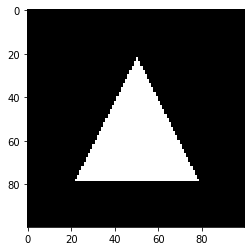

In [224]:
triangles = [Triangle(Vec3(-1,-1,3),Vec3(1,-1,3),Vec3(0,1,3))]
camera(Vec3(0),100,100,60,triangles)

Congratulations! 
We have our first triangle!

To conclude this part 2, we will make the ray tracing function a little bit more fun as a bonus.
The further a triangle is, the darker we will shade it.

For this it is important that we look at the first triangle that a ray hits.

In [225]:
def trace_ray(ray, triangles):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :return: color
    '''
    
    has_hit = False
    closest_hit = inf
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            closest_hit = min(closest_hit,t)
    
    # If there is a hit, return the color based on the distance
    if has_hit:
        return Vec3(1.0)/closest_hit
    # Else, return black
    return Vec3(0.0)

To test this we will use a world with 3 triangles

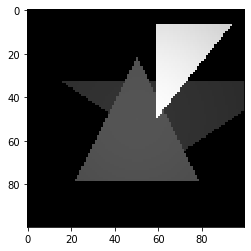

In [226]:

triangles = [Triangle(Vec3(-1,-1,3),Vec3(0,1,3),Vec3(1,-1,3)),
             Triangle(Vec3(0.5,0.5,1),Vec3(0.1,0,1),Vec3(0.1,0.5,1)),
             Triangle(Vec3(-2,1,5),Vec3(4,1,5),Vec3(1,0-1,5))]
camera(Vec3(0),100,100,60,triangles)

Now that we have a basic ray-tracer, we are ready to continue our journey to more advanced topics!

## Part 3: Double rainbow
Black and white triangles are admittedly pretty sweet, but imagine blue, green or even yellow triangles!
For this we need two new features,

- material properties for triangles
- light sources

### Material properties
The material properties will be:

- diffuse reflectivity (Kd)
- specular reflectivity (Ks)
- shininess (Ns)

The diffuse reflectivity is the amount of light that falls on the object that will be bounced back from its surface into all directions.
If you where to shine a laser pointer at a object with high diffuse reflectivity, you would see a bright spot on the surface of that object on the spot where the laser hits, no matter from which side you are looking.
Diffuse reflections happen mostly on rough surfaces, for example with paper.

Specular reflections are mirror like reflections where the light that falls on the object gets reflected with the same angle from the object.
I do not recommend that you try the experiment with the laser on a specular surface.
If the surface is purely specular (not diffuse), you wouldn't even see that there is a laser shining on the object, unless you move your head in just the "right" spot.
When your eye is directly in the mirror direction of the incoming laser beam it's time to go to the eye-doctor, since it will look like you are directly looking into the laser beam.
This happens with smooth surfaces, for example a highly polished piece of metal

The shininess property is a measure of how smooth the surface is.
Most materials are not perfect mirrors.
They might be shiny, but the specular reflection has a bit of spread.
Higher shininess means that the surface is more mirror like, and thus the spread of the specular reflection is lower.

### Light sources

The material properties all mention "incoming light". 
The light has to come from a source.
For this we need a "PointLight" class.
PointLights have only two properties,
- how much light they emit (including the color)
- the position of the light

### Implementation

Lets start with the light sources!
We will also add a "get_pos" function to get the position of the light.
This might seem like a un-pythonic thing to do, but it will be useful later on!

In [227]:
class PointLight:
    def __init__(self, pos, color):
        '''
        Point light to make your world a little bit happier.
        :param pos: position of the light
        :param color: the color of the light
        '''
        self.pos = pos
        self.color = color
    
    def get_pos(self):
        '''
        Gets the position of the light source.
        :return: Light source position
        '''
        return self.pos


Now we will add material properties to triangles.
It will be useful to know the surface normals of all triangles when we calculate the shadings.
Therefore we will calculate the normals during the construction of triangles. 


In [228]:
class Triangle:
    def __init__(self, a, b, c, Kd, Ks, Ns):
        '''
        Basic triangle class.
        :param a: First corner
        :param b: Second corner
        :param c: Third corner
        :param Kd: Diffuse reflectivity
        :param Ks: Specular reflectivity
        :param Ns: Shininess
        '''
        self.a = a
        self.b = b
        self.c = c
        self.Kd = Kd
        self.Ks = Ks
        self.Ns = Ns
        
        self.normal = (b-a).cross_product(c-a).unit()

Lets start with a function that calculates the amount or diffusely reflected light before we do the specular light.
For diffuse light, it is not important where the camera is, because the light is evenly distributed all directions.


In [229]:
def diffuse(triangle, posHit, lightPos):
    '''
    Calculate the fraction of diffusely reflected light.
    :param triangle: The triangle that has been hit
    :param posHit: The position where it was hit
    :param lightPos: The position of the light source
    :return: The fraction of incoming light that is diffusely reflected
    '''
    lightDirection = (lightPos - posHit).unit()
    return max(lightDirection.dot(triangle.normal), 0) * triangle.Kd


In contrast, for specular reflections, the location of the camera is important.


In [230]:
def specular(triangle, posHit, lightPos, cameraPos):
    '''
    Calculate the fraction of specularly reflected light.
    :param triangle: The triangle that has been hit
    :param posHit: The position where it was hit
    :param lightPos: The position of the light source
    :param cameraPos: The position of the camera
    :return: The fraction of incoming light that is specularly reflected
    '''
    lightDirection = (lightPos - posHit).unit()
    reflec = (2 * (triangle.normal.dot(lightDirection)) * triangle.normal - lightDirection)
    spec = max((cameraPos - posHit).unit().dot(reflec), 0)
    return spec ** triangle.Ns * triangle.Ks

There are only two more things that we need to do in order to render the most beautifully colored triangles the world has ever seen.
- update the trace_ray function to use our new shading functions.
- update the camera to use our new trace_ray function

In [231]:
def trace_ray(ray, triangles, lights):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :param lights: list of lights in the world
    :return: color
    '''
    
    has_hit = False
    closest_hit = inf
    
    # We now also want a variable to safe the triangle that we hit
    closest_tri = None
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            if t<closest_hit:
                closest_hit = t
                closest_tri = tri
    
    # If there is a hit, return the color based on its material properties and light sources
    if has_hit:
        # Calculate the hit position
        hit_pos = ray.origin+ray.direction*(closest_hit-EPSILON)
        
        # For all lights, calculate the diffuse and specular amounts of light
        col = Vec3(0.0)
        for light in lights:
            col += diffuse(closest_tri, hit_pos, light.get_pos()) * light.color
            col += specular(closest_tri, hit_pos, light.get_pos(), ray.origin) * light.color
        
        return col
    # Else, return black
    return Vec3(0.0)

Now that we are editing the camera function anyway, we might as well add another function!
When working with lights it can happen that objects appear so bright, that there is no way for your screen to display it.
This can result in weird looking images, and the triangles dont deserve that.
Especially not the super bright ones!
To fix this problem, we will clip all colors-brightness-values between 0 and 1.
They might still look a bit over-exposed at times (although I will try my best not to let that happen for most example renders in this tutorial),
but at least the colors wont be completely wrong.

In [232]:
import warnings

def camera(camera_pos, width, height, fov, triangles, lights):
    '''
    Renders a image of width*height pixels, of the world of triangles.
    As seen from the camera position
    The field of view is how "wide" the lens is.
    :param camera_pos: camera position
    :param width: horizontal pixels
    :param height: vertical pixels
    :param fov: field of view
    :param triangles: triangles in the world
    :param lights: list of lights in the world
    '''
    
    # Keep track if there has been a value that had to be clipped
    # Only the first time this happens we want to give a warning
    has_warned_clip = False
    
    image = []
    
    angle = tan(pi * 0.5 * fov / 180)
    aspect_ratio = width / height
    inv_width = 1/width
    inv_height = 1/height
    
    # For all pixels of the image
    for y in range(height):
        row = []
        for x in range(width):
            # Calculate the direction of the ray for this pixel
            xdir = (2 * x * inv_width - 1) * angle * aspect_ratio
            ydir = (1 - 2 * y * inv_height) * angle
            
            raydir = Vec3(xdir, ydir, 1)
            raydir.normalize()
            
            # Create the ray
            ray = Ray(camera_pos, raydir)
            
            # Trace the ray, and convert color from Vec3 to [r,g,b]
            col = trace_ray(ray, triangles, lights).toList()
            clipped_col = clip(col,0.0,1.0)
            if not has_warned_clip:
                if col != clipped_col:
                    warnings.warn("Image is clipping! Lights might be to bright..")
                    has_warned_clip = True
            row.append(clipped_col)
        image.append(row)
    
    plt.imshow(image)
    plt.show()

This should be all that we need!
It is again time to render a little scene :D

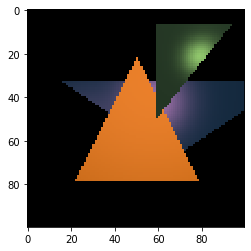

In [233]:
triangle_1 = Triangle(Vec3(-1,-1,3),
                      Vec3(0,1,3),
                      Vec3(1,-1,3),
                      Kd=Vec3(1.0,0.5,0.0),
                      Ks=Vec3(0.1,0.1,0.2),
                      Ns=1)
triangle_2 = Triangle(Vec3(0.5,0.5,1),
                      Vec3(0.1,0,1),
                      Vec3(0.1,0.5,1),
                      Kd=Vec3(0.2,0.3,0.2),
                      Ks=Vec3(0.6,0.8,0.4),
                      Ns=150)
triangle_3 = Triangle(Vec3(-2,1,5),
                      Vec3(4,1,5),
                      Vec3(1,0-1,5),
                      Kd=Vec3(0.1,0.2,0.3),
                      Ks=Vec3(0.8,0.4,0.6),
                      Ns=20)

light_1 = PointLight(pos=Vec3(1,1,-1),color=Vec3(0.7))
light_2 = PointLight(pos=Vec3(-3,0,-1),color=Vec3(0.2,0.2,0.2))

triangles = [triangle_1, triangle_2, triangle_3]
lights = [light_1, light_2]

camera(Vec3(0),100,100,60,triangles,lights)

## Part 4: Small triangles can cast big shadows
In this part we will add shadows to our ray-tracer!
Shadows come in two kinds.
- Hard shadows
- Soft shadows

![Hard_vs_soft_shadows](https://www.researchgate.net/profile/Joe_Kniss/publication/242383784/figure/fig3/AS:298469525868563@1448172088633/Left-Hard-shadows-from-a-point-light-source-Right-Soft-shadows-from-an-area-light.png) 
Hard shadows are what you would get with an infinitely small point light.
In the real world light sources are not infinitely small.
With bigger light sources, there is not only a "shadow" area and a "light" area, there is also a penumbra.
The penumbra is a transition area, that where only part of the light is occluded.

Its easier to start with hard-shadows.
Every time, before we use the diffuse and specular functions, we need to find out if there is an unobstructed path between the object and the light source.
 

In [234]:
def check_if_visible(pos, light_pos, triangle, triangles):
    '''
    Check if the point on the triangle is visible from the light source.
    :param pos: Hit point
    :param light_pos: Light source position
    :param triangle: The triangle that is looked at
    :param triangles: All triangles in the world
    :return: Is the triangle visible
    '''
    direction = (pos - light_pos)
    direction.normalize()
    ray = Ray(light_pos, direction)
    
    has_hit = False
    closest_hit = inf
    closest_tri = None
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            if t<closest_hit:
                closest_hit = t
                closest_tri = tri
    
    if has_hit:
        return closest_tri == triangle
    return False

We can now put this function into the trace ray function!

In [235]:
def trace_ray(ray, triangles, lights):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :param lights: list of lights in the world
    :return: color
    '''
    
    has_hit = False
    closest_hit = inf
    
    # We now also want a variable to safe the triangle that we hit
    closest_tri = None
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            if t<closest_hit:
                closest_hit = t
                closest_tri = tri
    
    # If there is a hit, return the color based on its material properties and light sources
    if has_hit:
        # Calculate the hit position
        hit_pos = ray.origin+ray.direction*(closest_hit-EPSILON)
        
        # For all lights, calculate the diffuse and specular amounts of light
        col = Vec3(0.0)
        for light in lights:
            if check_if_visible(hit_pos,light.get_pos(),closest_tri,triangles):
                col += diffuse(closest_tri, hit_pos, light.get_pos()) * light.color
                col += specular(closest_tri, hit_pos, light.get_pos(), ray.origin) * light.color
        
        return col
    # Else, return black
    return Vec3(0.0)


Now that we always check for occlusions, its time to re-render our previous scene with our newly added shadow checking!
As long as you ran the previous render before this one, the scene (all triangles and lights) should still be saved, so we only have to call the render function now.

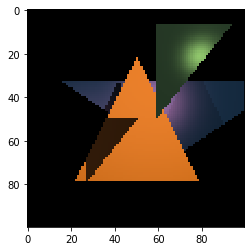

In [236]:
camera(Vec3(0),100,100,60,triangles,lights)

As you can see, the shadow calculations are working!
Now that we have finished what we set out to do in this chapter, it is ones again time for a little bonus :)
If you take a close look at the edges of the triangles, you can see that they appear to be blocky and pixelated.
Of course this is not the way that we want our triangles to look like.

To solve this problem, for every pixel in the image, we will not just trace one single ray, we will trace multiple rays, all in a slightly different direction. The reason for this is that pixels on an image sensor are not infinetly small, and we want to know the average of incoming light all the spots of the pixel.

To generate the rays, every time we calculate the possision of the pixel. But now that we know that pixels have a size larger than 0, we will randomly offset that location, in order to sample from all locations on the pixel.

In [237]:
SAMPLES_PER_PIXEL = 10

def camera(camera_pos, width, height, fov, triangles, lights):
    '''
    Renders a image of width*height pixels, of the world of triangles.
    As seen from the camera position
    The field of view is how "wide" the lens is.
    :param camera_pos: camera position
    :param width: horizontal pixels
    :param height: vertical pixels
    :param fov: field of view
    :param triangles: triangles in the world
    :param lights: list of lights in the world
    '''
    
    # Keep track if there has been a value that had to be clipped
    # Only the first time this happens we want to give a warning
    has_warned_clip = False
    
    image = []
    
    angle = tan(pi * 0.5 * fov / 180)
    aspect_ratio = width / height
    inv_width = 1/width
    inv_height = 1/height
    
    # For all pixels of the image
    for y in range(height):
        row = []
        for x in range(width):
            col = Vec3(0)

            for _ in range(SAMPLES_PER_PIXEL):
                # Calculate the direction of the ray for this pixel
                xdir = (2 * (x+random()) * inv_width - 1) * angle * aspect_ratio
                ydir = (1 - 2 * (y+random()) * inv_height) * angle

                raydir = Vec3(xdir, ydir, 1)
                raydir.normalize()

                # Create the ray
                ray = Ray(camera_pos, raydir)

                # Trace the ray
                col += trace_ray(ray, triangles, lights)
            
            # Average the samples
            col/=SAMPLES_PER_PIXEL
            col = col.toList()
            clipped_col = clip(col,0.0,1.0)
            if not has_warned_clip:
                if col != clipped_col:
                    warnings.warn("Image is clipping! Lights might be to bright..")
                    has_warned_clip = True
            row.append(clipped_col)
        image.append(row)
    
    plt.imshow(image)
    plt.show()

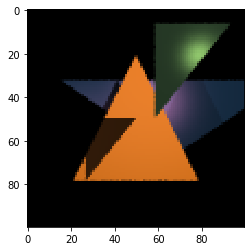

In [238]:
SAMPLES_PER_PIXEL = 20
camera(Vec3(0),100,100,60,triangles,lights)

By adjusting the amount of samples per pixel, you can get an increasingly smooth edge on your triangle. Be carefull though.
If you want to many samples per pixel, it might be the perfect moment to make yourself some tea, because the more samples per pixel the longer the render will take.

As you can see, the edges all look a lot cleaner now!
Now that we are able to make hard shadows, it is time to progress to soft shadows!

## Part 5: A soft shadow is a happy shadow

Making shadows soft is relativly simple.
As previously discussed, real world light sorces are not infinitly small.
To moddel this, we will simply move our light source a little bit everytime it gets sampled.
To do this we will first add a size and offset to the PointLight class.
We the add the move_light function that generates a random offset.
Finaly we update the get_pos function to return the possision with the added random offset.

In [239]:
class PointLight:
    def __init__(self, pos, color, size):
        '''
        Point light to make your world a little bit happier.
        :param pos: position of the light
        :param color: the color of the light
        :param size: the size of the light
        '''
        self.pos = pos
        self.offset = Vec3()
        self.color = color
        self.size = size
        
    def move_light(self):
        '''
        Generate a random offset for this light.
        The larger the light size, the larger the offsets
        '''
        self.offset = Vec3((random() - 0.5) * self.size,
                            (random() - 0.5) * self.size,
                            (random() - 0.5) * self.size)
    
    def get_pos(self):
        '''
        Gets the position of the light source.
        The possition is translated by the offset vector
        :return: Light source position
        '''
        return self.pos + self.offset

Now we need to update the light possition in the raytrace function.
We do that every time that a light is sampled from.

In [240]:
def trace_ray(ray, triangles, lights):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :param lights: list of lights in the world
    :return: color
    '''
    
    has_hit = False
    closest_hit = inf
    closest_tri = None
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            if t<closest_hit:
                closest_hit = t
                closest_tri = tri
    
    # If there is a hit, return the color based on its material properties and light sources
    if has_hit:
        # Calculate the hit position
        hit_pos = ray.origin+ray.direction*(closest_hit-EPSILON)
        
        # For all lights, calculate the diffuse and specular amounts of light
        col = Vec3(0.0)
        for light in lights:
            # Randomly move the light a little bit
            light.move_light()
            if check_if_visible(hit_pos,light.get_pos(),closest_tri,triangles):
                col += diffuse(closest_tri, hit_pos, light.get_pos()) * light.color
                col += specular(closest_tri, hit_pos, light.get_pos(), ray.origin) * light.color
        
        return col
    # Else, return black
    return Vec3(0.0)

This should be all!
Now it is time for another test :)
The only thing that we need to do is updating the lights in our previous scene with a size.

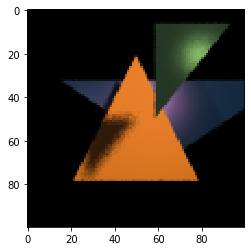

In [241]:
light_1 = PointLight(pos=Vec3(1,1,-1),color=Vec3(0.7), size=0.2)
light_2 = PointLight(pos=Vec3(-3,0,-1),color=Vec3(0.2,0.2,0.2), size=0.3)

lights = [light_1, light_2]

SAMPLES_PER_PIXEL = 40
camera(Vec3(0),100,100,60,triangles,lights)

As you can see there is a nice shadow now!
But you might notice a little problem.. Uhm, I mean, Challenge!
Rendering the image takes quite a while, and the image is a bit noisy.
In the next chapter we will explore two techniques so fix this :)

## Part 6: Thinking outside of the box
We will start by making a new scene to render.
This scene will have a very poorly drawn car on it.

Then we will add one of the most basic acceleration structers, a boundingbox.
This box surrounds the whole scene.
If a ray does not hit the box, it is imeadiatly clear that it will not hit anything at all.
This can help speed up the rendering process!

Lets start with the new scene!

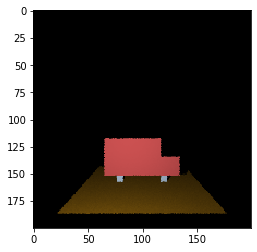

In [242]:
ground = [Triangle(Vec3(-0.9,-1,2),Vec3(-0.9,-1,4),Vec3(0.9,-1,2),Kd=Vec3(1.0,0.7,0.1),Ks=Vec3(0.1,0.1,0.2),Ns=1),
          Triangle(Vec3(0.9,-1,2),Vec3(-0.9,-1,4),Vec3(0.9,-1,4),Kd=Vec3(1.0,0.7,0.1),Ks=Vec3(0.1,0.1,0.2),Ns=1)]

body = [Triangle(Vec3(-0.6,-0.9,3),Vec3(-0.6,-0.3,3),Vec3(0.3,-0.9,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1),
        Triangle(Vec3(0.3,-0.9,3),Vec3(-0.6,-0.3,3),Vec3(0.3,-0.3,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1),
        Triangle(Vec3(0.3,-0.9,3),Vec3(0.3,-0.6,3),Vec3(0.6,-0.9,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1),
        Triangle(Vec3(0.6,-0.9,3),Vec3(0.3,-0.6,3),Vec3(0.6,-0.6,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1)]

wheels = [Triangle(Vec3(-0.4,-1,3),Vec3(-0.4,-0.9,3),Vec3(-0.3,-1,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1),
          Triangle(Vec3(-0.3,-1,3),Vec3(-0.4,-0.9,3),Vec3(-0.3,-0.9,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1),
          Triangle(Vec3(0.3,-1,3),Vec3(0.3,-0.9,3),Vec3(0.4,-1,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1),
          Triangle(Vec3(0.4,-1,3),Vec3(0.3,-0.9,3),Vec3(0.4,-0.9,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1)]

triangles = ground + body + wheels
lights = [PointLight(pos=Vec3(-0.3,-0.4,1),color=Vec3(0.8),size=0.1)]

SAMPLES_PER_PIXEL = 4
camera(Vec3(0),200,200,60,triangles,lights)

Alright, alright, the car might not look al that fast, but I'm sure it gets you from a to b anytime you need it.

To speed up the rendering process, we will create a bounding box.
This box will be always aligned with the coordinate system.
This is called an axis alligned bounding box, or AABB for short.

Our AABB only needs to keep track of two corners.
The corner with the smallest x,y and z values, and the corner with the largest x,y and z values.

In [243]:
class AABB:
    def __init__(self, min_corner, max_corner):
        '''
        Axis aligned bounding box to contain all the triangles in the scene.
        If a ray does not hit this box, it will also miss all triangles.
        :param min_corner: vector discribing the corner with the lowest x,y and z values
        :param max_corner: vector discribing the corner with the highest x,y and z values
        '''
        self.min_corner = min_corner
        self.max_corner = max_corner

No we can add a function to the ray class that checks if it intersects with an AABB

In [244]:
def ray_AABB_intersect(self, other):
    # Find out what the first and last time is where the ray has the correct x coordinate
    tmin = (other.min_corner.x - self.origin.x) / self.direction.x
    tmax = (other.max_corner.x - self.origin.x) / self.direction.x

    if tmin > tmax:
        tmin, tmax = tmax, tmin
    
    # Also Find out what the first and last time is where the ray has the correct y coordinate
    tymin = (other.min_corner.y - self.origin.y) / self.direction.y
    tymax = (other.max_corner.y - self.origin.y) / self.direction.y

    if tymin > tymax:
        tymin, tymax = tymax, tymin
        
    # If the first time the x coordinate is correct is later than the last time the y coordinate is correct,
    # there is no hit.
    # There is also no hit first time the y coordinate is correct happens after the last time the x is correct
    if (tmin > tymax) or (tymin > tmax):
        return False
    
    # Now we want to know the window of time where both the x and y are correct
    if tymin > tmin:
        tmin = tymin

    if tymax < tmax:
        tmax = tymax

    # Calculate the first and last time the ray has the correct z coordinate
    tzmin = (other.min_corner.z - self.origin.z) / self.direction.z
    tzmax = (other.max_corner.z - self.origin.z) / self.direction.z

    if tzmin > tzmax:
        tzmin, tzmax = tzmax, tzmin
    
    # If the first time the z coordinate is correct happens after the window where x and y are correct,
    # there is no hit.
    # There is also no hit if the last time the z coordinate is correct happens before the x and y are correct
    if (tmin > tzmax) or (tzmin > tmax):
        return False
    
    # If there is a point on the ray where all the coordinates are inside the AABB, there is a hit!
    return True

# Add the function to the ray class
Ray.ray_AABB_intersect = ray_AABB_intersect

Now we need to find the smallest AABB that fully contains all triangles.
This is done by looping over all triangles.
The minimal and maximal values of the coordinates of all the corners of triangles are recorded.
Those coordinates are used to build the AABB

In [245]:
def create_aabb(triangles):
    # Find the smallest x, y and z coordinate values
    x_min = min(min(triangle.a.x,triangle.b.x,triangle.c.x) for triangle in triangles)
    y_min = min(min(triangle.a.y,triangle.b.y,triangle.c.y) for triangle in triangles)
    z_min = min(min(triangle.a.z,triangle.b.z,triangle.c.z) for triangle in triangles)
    
    # Find the largest x, y and z coordinate values
    x_max = max(max(triangle.a.x,triangle.b.x,triangle.c.x) for triangle in triangles)
    y_max = max(max(triangle.a.y,triangle.b.y,triangle.c.y) for triangle in triangles)
    z_max = max(max(triangle.a.z,triangle.b.z,triangle.c.z) for triangle in triangles)
    
    min_corner = Vec3(x_min, y_min, z_min)
    max_corner = Vec3(x_max, y_max, z_max)
    
    return AABB(min_corner, max_corner)

Lets update the camera function to calculate the AABB and to give it to the ray_trace function

In [246]:
def camera(camera_pos, width, height, fov, triangles, lights):
    '''
    Renders a image of width*height pixels, of the world of triangles.
    As seen from the camera position
    The field of view is how "wide" the lens is.
    :param camera_pos: camera position
    :param width: horizontal pixels
    :param height: vertical pixels
    :param fov: field of view
    :param triangles: triangles in the world
    :param lights: list of lights in the world
    '''
    has_warned_clip = False
    
    image = []
    
    angle = tan(pi * 0.5 * fov / 180)
    aspect_ratio = width / height
    inv_width = 1/width
    inv_height = 1/height
    
    # Create the AABB
    bounding_box = create_aabb(triangles)

    for y in range(height):
        row = []
        for x in range(width):
            col = Vec3(0)

            for _ in range(SAMPLES_PER_PIXEL):
                xdir = (2 * (x+random()) * inv_width - 1) * angle * aspect_ratio
                ydir = (1 - 2 * (y+random()) * inv_height) * angle

                raydir = Vec3(xdir, ydir, 1)
                raydir.normalize()
                ray = Ray(camera_pos, raydir)

                # Trace the ray with the bounding box
                col += trace_ray(ray, triangles, lights, bounding_box)
            
            col/=SAMPLES_PER_PIXEL
            col = col.toList()
            clipped_col = clip(col,0.0,1.0)
            if not has_warned_clip:
                if col != clipped_col:
                    warnings.warn("Image is clipping! Lights might be to bright..")
                    has_warned_clip = True
            row.append(clipped_col)
        image.append(row)
    
    plt.imshow(image)
    plt.show()

Finaly, the ray_trace function needs an update.
Everytime we will check if the ray hits the AABB first.
If it does not, we can return black.

In [247]:
def trace_ray(ray, triangles, lights, bounding_box):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :param lights: list of lights in the world
    :return: color
    '''
    
    if not ray.ray_AABB_intersect(bounding_box):
        return Vec3(0.0)
    
    has_hit = False
    closest_hit = inf
    closest_tri = None
    
    # Loop over all triangles
    for tri in triangles:
        # And if there is a hit
        t = ray.triangle_intersection_test(tri)
        if t:
            # Take note of the closest one
            has_hit = True
            if t<closest_hit:
                closest_hit = t
                closest_tri = tri
    
    # If there is a hit, return the color based on its material properties and light sources
    if has_hit:
        # Calculate the hit position
        hit_pos = ray.origin+ray.direction*(closest_hit-EPSILON)
        
        # For all lights, calculate the diffuse and specular amounts of light
        col = Vec3(0.0)
        for light in lights:
            # Randomly move the light a little bit
            light.move_light()
            if check_if_visible(hit_pos,light.get_pos(),closest_tri,triangles):
                col += diffuse(closest_tri, hit_pos, light.get_pos()) * light.color
                col += specular(closest_tri, hit_pos, light.get_pos(), ray.origin) * light.color
        
        return col
    # Else, return black
    return Vec3(0.0)

Now we can finaly do another render!
Can you see how much faster it already is? :)

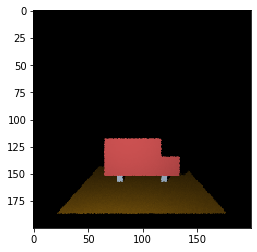

In [248]:
SAMPLES_PER_PIXEL = 4
camera(Vec3(0),200,200,60,triangles,lights)

The render should be about 2x as fast, because all the rays in the top half of the image imidiatly know that they wont hit anything and no triangle intersections have to be preformed for those rays.
Speed is ofcourse very fun.
But now it is time to work on making the image more beatifull again!
Dont worry though, because we will revisit performance later.

## Part 7: Self reflection is key
Our car looks a bit lonley now, but,
moddeling another car takes quite a lot of time and effort.
There is however a simple solution for this problem!
If we make the floor reflective, it will look like we have two cars!

In this chapter we will implement reflections.
When a ray hits a reflective surface, we will cast another ray.
This reflection ray gets added to the output colour.

Lets start by adding a reflexifity property to triangles

In [249]:
class Triangle:
    def __init__(self, a, b, c, Kd, Ks, Ns, refl):
        '''
        Basic triangle class.
        :param a: First corner
        :param b: Second corner
        :param c: Third corner
        :param Kd: Diffuse reflectivity
        :param Ks: Specular reflectivity
        :param Ns: Shininess
        :param refl: mirror like reflectivity
        '''
        self.a = a
        self.b = b
        self.c = c
        self.Kd = Kd
        self.Ks = Ks
        self.Ns = Ns
        self.refl = refl
        
        self.normal = (b-a).cross_product(c-a).unit()

Now that triangles have the reflectivity we need to update the ray_trace function to trace the reflection rays

In [250]:
def trace_ray(ray, triangles, lights, bounding_box):
    '''
    Returns the color of the ray.
    Color changes depending on the distance to the hit
    :param ray: Ray that has been shot into the world
    :param triangles: list of triangles in the world
    :param lights: list of lights in the world
    :return: color
    '''
    
    if not ray.ray_AABB_intersect(bounding_box):
        return Vec3(0.0)
    
    has_hit = False
    closest_hit = inf
    closest_tri = None
    
    for tri in triangles:
        t = ray.triangle_intersection_test(tri)
        if t:
            has_hit = True
            if t<closest_hit:
                closest_hit = t
                closest_tri = tri
    
    if has_hit:
        hit_pos = ray.origin+ray.direction*(closest_hit-EPSILON)
        
        col = Vec3(0.0)
        for light in lights:
            light.move_light()
            if check_if_visible(hit_pos,light.get_pos(),closest_tri,triangles):
                col += diffuse(closest_tri, hit_pos, light.get_pos()) * light.color
                col += specular(closest_tri, hit_pos, light.get_pos(), ray.origin) * light.color
        
        # If the triangle is mirror-like
        if closest_tri.refl > 0:
            # Calculate the direction of the reflection
            reflec_direction = (ray.direction - 2 * (closest_tri.normal.dot(ray.direction)) * closest_tri.normal)
            
            # Create a new ray
            bounce_ray = Ray(hit_pos, reflec_direction)
            
            # Trace the new ray
            col += trace_ray(bounce_ray, triangles, lights, bounding_box) * closest_tri.refl
        
        return col
    # Else, return black
    return Vec3(0.0)

Now we can re-render our scene!
Lets just make the ground reflective for now.

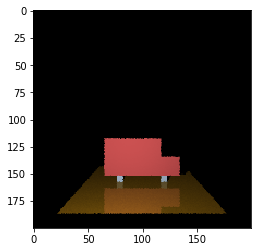

In [251]:
ground = [Triangle(Vec3(-0.9,-1,2),Vec3(-0.9,-1,4),Vec3(0.9,-1,2),Kd=Vec3(1.0,0.7,0.1),Ks=Vec3(0.1,0.1,0.2),Ns=1, refl=0.2),
          Triangle(Vec3(0.9,-1,2),Vec3(-0.9,-1,4),Vec3(0.9,-1,4),Kd=Vec3(1.0,0.7,0.1),Ks=Vec3(0.1,0.1,0.2),Ns=1, refl=0.2)]

body = [Triangle(Vec3(-0.6,-0.9,3),Vec3(-0.6,-0.3,3),Vec3(0.3,-0.9,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1, refl=0),
        Triangle(Vec3(0.3,-0.9,3),Vec3(-0.6,-0.3,3),Vec3(0.3,-0.3,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1, refl=0),
        Triangle(Vec3(0.3,-0.9,3),Vec3(0.3,-0.6,3),Vec3(0.6,-0.9,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1, refl=0),
        Triangle(Vec3(0.6,-0.9,3),Vec3(0.3,-0.6,3),Vec3(0.6,-0.6,3),Kd=Vec3(0.6,0.2,0.2),Ks=Vec3(0.4,0.2,0.2),Ns=1, refl=0)]

wheels = [Triangle(Vec3(-0.4,-1,3),Vec3(-0.4,-0.9,3),Vec3(-0.3,-1,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1, refl=0),
          Triangle(Vec3(-0.3,-1,3),Vec3(-0.4,-0.9,3),Vec3(-0.3,-0.9,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1, refl=0),
          Triangle(Vec3(0.3,-1,3),Vec3(0.3,-0.9,3),Vec3(0.4,-1,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1, refl=0),
          Triangle(Vec3(0.4,-1,3),Vec3(0.3,-0.9,3),Vec3(0.4,-0.9,3),Kd=Vec3(0.6,0.7,0.8),Ks=Vec3(0.2,0.2,0.2),Ns=1, refl=0)]

triangles = ground + body + wheels
lights = [PointLight(pos=Vec3(-0.3,-0.4,1),color=Vec3(0.8),size=0.1)]

SAMPLES_PER_PIXEL = 4
camera(Vec3(0),200,200,60,triangles,lights)

That looks shiny! I love it :)
Now it a good time for a little confession..
I wanted the car to look like lightning McQueen, my favorite car.
Well.. It is red, so thats a good start, but it doesnt look as fast as McQueen.
To compensate for my terible moddeling skills, we will just make the rendering lightning fast!